In [1387]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pandas_datareader import data

# IBM, MMM, ABBV, ALV, GOOGL, AMZN, AMGN, ABI, AAPL, BHP, BA, BP, BATS, CVX, CSCO, C, KO, DD, XOM, FB, GE, GSK, HSBA, INTC
# JNJ, JPM, MA, MCD, MRK, MSFT, NESN, NOVN, NVDA, ORCL, PEP, PFE, PM, PG, ROG, RY, RDSA, SMSN, SAN, SIE, TSM, TOT, V, TM
# WMT, DIS

tf.random.set_seed(8)
start = "2017"
end = "2022"
source = "yahoo"
tickers = ["DIS"]

df = pd.concat([data.DataReader(t, source, start, end) for t in tickers]).reset_index()
dates = df["Date"]
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2017-01-03,106.900002,105.209999,105.300003,106.080002,8884300.0,101.584358
1,2017-01-04,107.500000,106.250000,106.639999,107.440002,8322000.0,102.886726
2,2017-01-05,107.620003,106.790001,107.169998,107.379997,6303000.0,102.829254
3,2017-01-06,109.349998,107.750000,108.019997,108.980003,9551300.0,104.361458
4,2017-01-09,108.830002,108.110001,108.580002,108.360001,6195200.0,103.767723


In [1370]:
cols = list(df)[3:5]
df_train = df[cols].astype(float)
df_train
# df_plt = df_train.tail(5000)
# df_plt.plot.line()

,Open,Close
0,108.099998,108.970001
1,108.480003,106.330002
2,107.940002,109.610001
3,109.910004,110.559998
4,111.800003,111.419998
...,...,...
752,152.880005,152.800003
753,152.619995,155.199997
754,154.559998,154.869995
755,155.710007,155.929993


In [1371]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaled = scaler.fit_transform(df_train)
scaled

array([[0.20406223, 0.1998278 ],
       [0.20734663, 0.17709857],
       [0.20267937, 0.20533791],
       ...,
       [0.60561795, 0.59500639],
       [0.61555753, 0.6041325 ],
       [0.61694031, 0.59517862]])

In [1372]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(scaled, test_size=0.25, random_state=0)
print(train.shape)
print(test.shape)

(567, 2)
(190, 2)


In [1434]:
days_future = 7
days_past = 14

train_X = []
train_y = []
test_X = []
test_y = []

for i in range(days_past, len(train) - days_future + 1):
    train_X.append(train[i - days_past:i, 0:train.shape[1]])
    train_y.append(train[i + days_future - 1:i + days_future, 0])
    
for i in range(days_past, len(test) - days_future + 1):
    test_X.append(test[i - days_past:i, 0:test.shape[1]])
    test_y.append(test[i + days_future - 1:i + days_future, 0])
    
train_X, train_y, test_X, test_y = np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y)
    
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(547, 14, 2)
(547, 1)
(170, 14, 2)
(170, 1)


In [1435]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Layer
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(64, activation="relu", input_shape = (train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(64, activation="relu", return_sequences=True))
# model.add(LSTM(64, activation="relu", return_sequences=True))
model.add(LSTM(32, activation="relu", return_sequences=False, dropout=0.1))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = "mean_squared_error")
model.summary()

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_198 (LSTM)              (None, 14, 64)            17152     
_________________________________________________________________
lstm_199 (LSTM)              (None, 14, 64)            33024     
_________________________________________________________________
lstm_200 (LSTM)              (None, 32)                12416     
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 33        
Total params: 62,625
Trainable params: 62,625
Non-trainable params: 0
_________________________________________________________________


In [1436]:
history = model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(test_X, test_y), verbose=1)

Epoch 1/10
9/9 [==============================] - 11s 380ms/step - loss: 0.2926 - val_loss: 0.2288
Epoch 2/10
9/9 [==============================] - 0s 47ms/step - loss: 0.1785 - val_loss: 0.0680
Epoch 3/10
9/9 [==============================] - 0s 45ms/step - loss: 0.0623 - val_loss: 0.0624
Epoch 4/10
9/9 [==============================] - 0s 47ms/step - loss: 0.0616 - val_loss: 0.0682
Epoch 5/10
9/9 [==============================] - 0s 45ms/step - loss: 0.0603 - val_loss: 0.0627
Epoch 6/10
9/9 [==============================] - 0s 46ms/step - loss: 0.0570 - val_loss: 0.0615
Epoch 7/10
9/9 [==============================] - 0s 47ms/step - loss: 0.0544 - val_loss: 0.0611
Epoch 8/10
9/9 [==============================] - 0s 49ms/step - loss: 0.0559 - val_loss: 0.0609
Epoch 9/10
9/9 [==============================] - 0s 48ms/step - loss: 0.0566 - val_loss: 0.0612
Epoch 10/10
9/9 [==============================] - 0s 47ms/step - loss: 0.0540 - val_loss: 0.0602


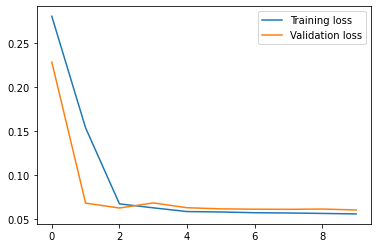

In [1437]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [1438]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
future = days_future + days_past

# days_past?
prediction_dates = pd.date_range(list(dates)[-(future-6)], periods=future, freq=us_bd).tolist()

prediction = model.predict(train_X[-future:])

In [1439]:
prediction_copies = np.repeat(prediction, df_train.shape[1], axis=-1)
y_forecast = scaler.inverse_transform(prediction_copies)[:,0]

In [1440]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2021-12-1'] 

<ipython-input-1440-6bb0c6eefd49>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


In [1443]:
forecast_dates = []
for time_i in prediction_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_forecast})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
df_forecast['Open'] = df_forecast['Open'] + 6

C:\Users\david\anaconda3v2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\david\anaconda3v2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Open'>

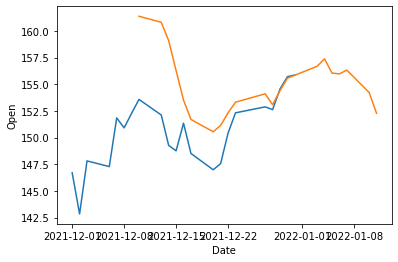

In [1444]:
import seaborn as sns

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])

In [1384]:
df_forecast

,Date,Open
0,2021-12-10,160.638138
1,2021-12-13,160.141800
2,2021-12-14,158.288025
3,2021-12-15,155.162018
4,2021-12-16,152.097321
5,2021-12-17,150.112091
6,2021-12-20,148.857498
7,2021-12-21,149.522827
8,2021-12-22,150.804398
9,2021-12-23,151.822510


In [1388]:
result = df.merge(df_forecast, how="outer", on=["Date", "Open"])
result

,Date,High,Low,Open,Close,Volume,Adj Close
0,2017-01-03,106.900002,105.209999,105.300003,106.080002,8884300.0,101.584358
1,2017-01-04,107.500000,106.250000,106.639999,107.440002,8322000.0,102.886726
2,2017-01-05,107.620003,106.790001,107.169998,107.379997,6303000.0,102.829254
3,2017-01-06,109.349998,107.750000,108.019997,108.980003,9551300.0,104.361458
4,2017-01-09,108.830002,108.110001,108.580002,108.360001,6195200.0,103.767723
...,...,...,...,...,...,...,...
1275,2022-01-05,NaN,NaN,155.068192,NaN,NaN,NaN
1276,2022-01-06,NaN,NaN,155.105957,NaN,NaN,NaN
1277,2022-01-07,NaN,NaN,155.554504,NaN,NaN,NaN
1278,2022-01-10,NaN,NaN,153.362625,NaN,NaN,NaN


In [1389]:
result.to_csv("DIS_data.csv")